## CSC345 Coursework: Object Recognition

**Imports**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import skimage.feature
import tensorflow as tf
from sklearn.model_selection import train_test_split
##For Tuning
from kerastuner.tuners import RandomSearch
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow import keras
from keras.utils import np_utils
import pandas as pd
from pandas import DataFrame
import seaborn as sb
#Confusion Matrix
import sklearn.metrics as metrics


from sklearn.utils import shuffle

In [2]:
#Using GPU acceleration
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))


Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device



## Set Random Seed For Repeatable Results

In [4]:
np.random.seed(12)

**Display Image**

In [5]:
x_train = np.load('trnImage.npy')
y_train = np.load('trnLabel.npy')
x_test = np.load('tstImage.npy')
y_test = np.load('tstLabel.npy')




In [6]:
print(f'X_train sample shape: {x_train.shape[0:3]}')
print(f'Number of Training Samples: {x_train.shape[3]}')
print(f'Number of Testing Samples: {x_test.shape[3]}')
print(f'Number Of Classes:{len(np.unique(y_train))}')

print(f'The classes are labelled as: {np.unique(y_train)}')

X_train sample shape: (32, 32, 3)
Number of Training Samples: 10000
Number of Testing Samples: 1000
Number Of Classes:10
The classes are labelled as: [0 1 2 3 4 5 6 7 8 9]


## Load And Visualise Data

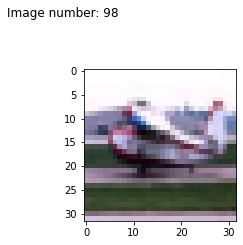

In [7]:
# Select an Image From Training Set

image_index = 98 # pick a specific image
image = x_train[:, :, :, image_index]

plt.figure()

plt.subplot(122)
plt.imshow(image)
plt.suptitle(f'Image number: {image_index}')
plt.show(block=False)

## Transpose the Data

In [8]:
height, width, colour, samples = x_train.shape #load the shape into independant variables

print(height, width, colour) #display the variables passed into the CNN
print(x_train.shape) #display the original shape
x_train = np.transpose(x_train, [3, 0,1,2]) #Reshape from HWCS
x_test = np.transpose(x_test, [3, 0,1,2]) #Into SHWC
print(x_train.shape)


32 32 3
(32, 32, 3, 10000)
(10000, 32, 32, 3)


In [9]:
x_train, y_train = shuffle(x_train, y_train, random_state=0)
x_test, y_test = shuffle(x_test, y_test, random_state=0)

## Convert to One-Hot Encoding

In [10]:
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

## Normalise Data Set

In [11]:
def normalise(x):
    minimum = np.min(x)
    maximum = np.max(x)
    x = (x-minimum) / (maximum-minimum)
    return x

In [12]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train = normalise(x_train)
x_test = normalise(x_test)

## Instanstiate A C.N.N Model with 3 layers

**This model uses 2 conv layers with the relu activation function.  
It also uses maxPooling between each conv layer.  
Dropout is used in order to regularize the neural network by switching certain nodes off with certain probabilities.** 

In [240]:


SGDmodel = tf.keras.Sequential(layers=[
    #First Layer
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(height, width, colour)),
    
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.2),
    #Second Layer
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.4),
    #Third Layer
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.6),
    
    #flatten
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation='relu'),
    #Dense Layer
    
    tf.keras.layers.Dense(10, activation='softmax')
])



## Running the Model With Stochastic Gradient Descent

In [241]:

SGDmodel.compile(optimizer=tf.keras.optimizers.SGD(), 
              loss=tf.keras.losses.CategoricalCrossentropy(), 
              metrics=tf.keras.metrics.CategoricalAccuracy())

In [242]:
history = SGDmodel.fit(x_train,y_train,epochs=30,
         validation_split=0.2, verbose = 2, batch_size=32)

Epoch 1/30
250/250 - 4s - loss: 2.3061 - categorical_accuracy: 0.0993 - val_loss: 2.2970 - val_categorical_accuracy: 0.1200
Epoch 2/30
250/250 - 4s - loss: 2.2861 - categorical_accuracy: 0.1128 - val_loss: 2.2791 - val_categorical_accuracy: 0.1800
Epoch 3/30
250/250 - 4s - loss: 2.2399 - categorical_accuracy: 0.1609 - val_loss: 2.2185 - val_categorical_accuracy: 0.2110
Epoch 4/30
250/250 - 4s - loss: 2.1643 - categorical_accuracy: 0.1894 - val_loss: 2.1178 - val_categorical_accuracy: 0.2130
Epoch 5/30
250/250 - 4s - loss: 2.0998 - categorical_accuracy: 0.2071 - val_loss: 2.0819 - val_categorical_accuracy: 0.2155
Epoch 6/30
250/250 - 4s - loss: 2.0705 - categorical_accuracy: 0.2247 - val_loss: 2.1526 - val_categorical_accuracy: 0.1805
Epoch 7/30
250/250 - 4s - loss: 2.0503 - categorical_accuracy: 0.2175 - val_loss: 2.0673 - val_categorical_accuracy: 0.2185
Epoch 8/30
250/250 - 4s - loss: 2.0364 - categorical_accuracy: 0.2326 - val_loss: 2.0145 - val_categorical_accuracy: 0.2365
Epoch 9/

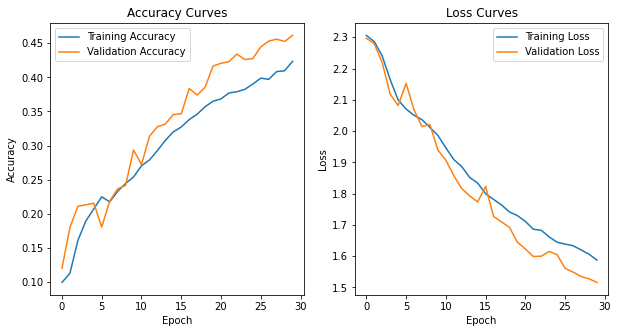

In [243]:
plt.figure(figsize=[10,5])
plt.subplot(121)
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy',
           'Validation Accuracy'])
plt.title('Accuracy Curves')

plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training Loss',
           'Validation Loss'])
plt.title('Loss Curves')
plt.show()

In [244]:
loss, accuracy = SGDmodel.evaluate(x_test,y_test, verbose = 0)
print('loss:', loss)
print('accuracy:', accuracy)


loss: 1.5877586603164673
accuracy: 0.4480000138282776


## Running Model With Adam Optimizer

In [245]:
Adammodel = tf.keras.Sequential(layers=[
    #First Layer
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(height, width, colour)),
    
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.2),
    #Second Layer
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.4),
    #Third Layer
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.6),
    
    #flatten
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation='relu'),
    #Dense Layer
    
    tf.keras.layers.Dense(10, activation='softmax')
])


In [246]:
Adammodel.compile(optimizer=tf.keras.optimizers.Adam(0.001), 
              loss=tf.keras.losses.CategoricalCrossentropy(), 
              metrics=tf.keras.metrics.CategoricalAccuracy())

In [247]:
history = Adammodel.fit(x_train,y_train,epochs=30,batch_size=32,
         validation_split=0.2, verbose = 2)

Epoch 1/30
250/250 - 4s - loss: 2.0214 - categorical_accuracy: 0.2276 - val_loss: 1.7624 - val_categorical_accuracy: 0.3640
Epoch 2/30
250/250 - 4s - loss: 1.7497 - categorical_accuracy: 0.3400 - val_loss: 1.6177 - val_categorical_accuracy: 0.4215
Epoch 3/30
250/250 - 4s - loss: 1.6309 - categorical_accuracy: 0.3889 - val_loss: 1.4979 - val_categorical_accuracy: 0.4645
Epoch 4/30
250/250 - 4s - loss: 1.5392 - categorical_accuracy: 0.4265 - val_loss: 1.4083 - val_categorical_accuracy: 0.4895
Epoch 5/30
250/250 - 4s - loss: 1.4923 - categorical_accuracy: 0.4543 - val_loss: 1.3301 - val_categorical_accuracy: 0.5410
Epoch 6/30
250/250 - 4s - loss: 1.4489 - categorical_accuracy: 0.4711 - val_loss: 1.3201 - val_categorical_accuracy: 0.5415
Epoch 7/30
250/250 - 4s - loss: 1.3933 - categorical_accuracy: 0.4886 - val_loss: 1.3190 - val_categorical_accuracy: 0.5225
Epoch 8/30
250/250 - 4s - loss: 1.3710 - categorical_accuracy: 0.5069 - val_loss: 1.2462 - val_categorical_accuracy: 0.5730
Epoch 9/

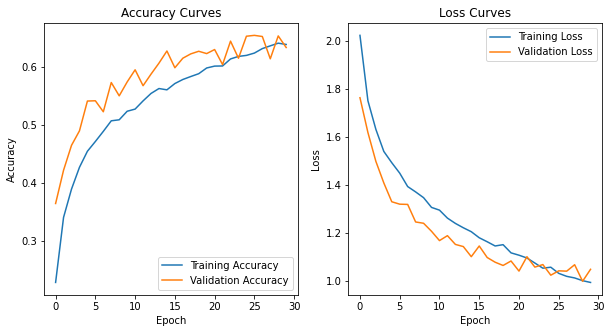

In [248]:
plt.figure(figsize=[10,5])
plt.subplot(121)
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy',
           'Validation Accuracy'])
plt.title('Accuracy Curves')

plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training Loss',
           'Validation Loss'])
plt.title('Loss Curves')
plt.show()

In [249]:
loss, accuracy = Adammodel.evaluate(x_test,y_test, verbose = 0)
print('loss:', loss)
print('accuracy:', accuracy)


loss: 1.136033535003662
accuracy: 0.5950000286102295


## Building A Keras Tuner Model

In [17]:
def build_model(hp):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(hp.Int('input_units', min_value=32, max_value=256, step=32), (3,3),input_shape=(height, width, colour)))
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    if(np.random.random() < 0.5):
        model.add(tf.keras.layers.Dropout(rate=hp.Float( 'dropout_1',
                    min_value=0.0,
                    max_value=0.5,
                    default=0.25,
                    step=0.05,
                )))
    for i in range(hp.Int('n_layers', 1, 4)):
        model.add(tf.keras.layers.Conv2D(hp.Int(f'conv_{i}_units', min_value=32, max_value=256, step=32), (3,3)))
        model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    if(np.random.random() < 0.5):
        model.add(tf.keras.layers.Dropout(rate=hp.Float( 'dropout_2',
                    min_value=0.0,
                    max_value=0.5,
                    default=0.25,
                    step=0.05,
                )))
    model.add(tf.keras.layers.Flatten())
    
    for i in range(hp.Int('n_connections', 1, 4)):
        model.add(tf.keras.layers.Dense(hp.Choice(f'n_nodes', values=[128,256,512,1024])))
        model.add(tf.keras.layers.Activation('relu'))
    
    
    model.add(tf.keras.layers.Dense(10))
    model.add(tf.keras.layers.Activation('softmax'))
    
    model.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss=tf.keras.losses.CategoricalCrossentropy(), 
              metrics=['accuracy'])
    
    return model

In [18]:
tuner_search=RandomSearch(build_model, objective='val_accuracy', max_trials=70, directory='random_search', executions_per_trial= 2,
    project_name='cifar10')

In [19]:
tuner_search.search(x_train, y_train, epochs=50, validation_split=0.2, batch_size=32)

Trial 61 Complete [00h 32m 31s]
val_accuracy: 0.5902499854564667

Best val_accuracy So Far: 0.6277499794960022
Total elapsed time: 05h 14m 34s

Search: Running Trial #62

Hyperparameter    |Value             |Best Value So Far 
input_units       |160               |128               
dropout_1         |0.15              |0.25              
n_layers          |2                 |2                 
conv_0_units      |224               |224               
n_connections     |2                 |3                 
n_nodes           |128               |256               
conv_1_units      |256               |192               
conv_2_units      |64                |128               
conv_3_units      |96                |96                
dropout_2         |0.4               |0.45              

Epoch 1/50
250/250 [==============================] - 23s 92ms/step - loss: 2.0021 - accuracy: 0.2406 - val_loss: 1.8098 - val_accuracy: 0.3435
Epoch 2/50
250/250 [==============================] - 23s

KeyboardInterrupt: 

In [20]:
tuner_search.results_summary()
tuned_model=tuner_search.get_best_models(num_models=1)[0]

Results summary
Results in random_search\cifar10
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
input_units: 128
dropout_1: 0.25
n_layers: 2
conv_0_units: 224
n_connections: 3
n_nodes: 256
conv_1_units: 192
conv_2_units: 128
conv_3_units: 96
dropout_2: 0.45
Score: 0.6277499794960022
Trial summary
Hyperparameters:
input_units: 128
dropout_1: 0.1
n_layers: 1
conv_0_units: 160
n_connections: 1
n_nodes: 1024
conv_1_units: 160
conv_2_units: 128
conv_3_units: 160
dropout_2: 0.2
Score: 0.6227499842643738
Trial summary
Hyperparameters:
input_units: 128
dropout_1: 0.4
n_layers: 1
conv_0_units: 160
n_connections: 2
n_nodes: 128
conv_1_units: 128
conv_2_units: 128
conv_3_units: 256
dropout_2: 0.25
Score: 0.6220000088214874
Trial summary
Hyperparameters:
input_units: 64
dropout_1: 0.45
n_layers: 1
conv_0_units: 256
n_connections: 2
n_nodes: 128
Score: 0.6189999878406525
Trial summary
Hyperparameters:
input_units: 64
dropout_1: 0.05
n_layers: 1

In [21]:
tuned_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 128)       3584      
_________________________________________________________________
activation (Activation)      (None, 30, 30, 128)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 224)       258272    
_________________________________________________________________
activation_1 (Activation)    (None, 13, 13, 224)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 192)       387264    
_________________________________________________________________
activation_2 (Activation)    (None, 11, 11, 192)       0

In [22]:
loss, accuracy = tuned_model.evaluate(x_test,y_test, verbose = 0)
print('loss:', loss)
print('accuracy:', accuracy)


loss: 2.095872640609741
accuracy: 0.5910000205039978


In [23]:
tuned_model.save('best_modelv2')
    #load model back in
  #  model = keras.models.load_model('savedModel')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: best_modelv2\assets


## Reload Saved Model

In [35]:
tuned_model = keras.models.load_model('best_modelv2') #load model, however I decided to reinstantiate the model


In [13]:

tuned_model = tf.keras.Sequential(layers=[
    #First Layer
    tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu', input_shape=(height, width, colour)),
    tf.keras.layers.Conv2D(256, (3, 3), padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.25),
    #Second Layer
    tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.Conv2D(512, (3, 3), padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.45),
    #Third Layer
    tf.keras.layers.Conv2D(1024, (3, 3), padding='same',activation='relu'),
    tf.keras.layers.Conv2D(1024, (3, 3), padding='same',activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.5),
    
    #flatten
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024,activation='relu'),
    
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10,activation='softmax')
    #Dense Layer
    
   
])

In [14]:
tuned_model.compile(optimizer=tf.keras.optimizers.Adam(0.001), 
              loss=tf.keras.losses.CategoricalCrossentropy(), 
              metrics=tf.keras.metrics.CategoricalAccuracy())

In [ ]:
history = tuned_model.fit(x_train,y_train,epochs=100,
         validation_split=0.2,batch_size=64, verbose = 1)

Epoch 1/100
 24/125 [====>.........................] - ETA: 5:20 - loss: 2.3115 - categorical_accuracy: 0.1035

In [ ]:
plt.figure(figsize=[10,5])
plt.subplot(121)
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy',
           'Validation Accuracy'])
plt.title('Accuracy Curves')

plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training Loss',
           'Validation Loss'])
plt.title('Loss Curves')
plt.show()

In [30]:

loss, accuracy = tuned_model.evaluate(x_test, y_test, verbose = 0)
print('Test Set loss:', loss)
print('Test Set accuracy:', accuracy)


Test Set loss: 1.6250972747802734
Test Set accuracy: 0.6079999804496765


## Tuned Model Is Selected For Confusion Matrix

In [167]:
confusion_matrix = metrics.confusion_matrix(y_test, tuned_model.predict(x_test))
plt.figure()

ValueError: Classification metrics can't handle a mix of multilabel-indicator and continuous-multioutput targets

In [151]:
print(y_pred)

[0 1 8 0 0 0 8 0 0 0 0 1 0 0 8 4 0 0 0 0 0 2 1 0 3 0 0 7 0 0 2 0 8 0 0 0 0
 0 8 0 0 0 8 8 0 8 8 0 0 0 0 2 5 1 0 0 0 9 0 0 8 9 0 0 0 0 1 0 0 8 3 0 9 9
 8 0 0 0 0 0 7 1 0 0 2 0 9 0 0 0 8 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
 0 1 8 1 7 1 1 1 2 1 8 1 1 9 9 1 1 1 1 8 1 1 1 1 1 1 1 1 1 1 1 8 1 1 1 2 1
 1 1 1 1 1 2 1 1 9 1 9 1 0 9 1 1 4 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 8 0 1 1 1
 1 1 1 1 1 8 1 1 1 1 1 1 1 1 1 2 6 6 7 2 4 4 2 2 4 0 0 4 6 2 4 0 2 4 2 2 2
 2 5 0 2 4 4 2 5 6 3 2 4 2 9 5 2 2 2 2 6 2 2 2 4 2 3 2 2 3 2 2 5 2 3 4 9 5
 4 2 4 1 3 2 5 5 4 2 0 2 5 5 2 6 2 2 3 3 2 2 0 2 5 2 2 2 6 4 2 9 2 3 4 5 0
 0 5 7 3 3 5 5 3 4 5 3 7 3 3 4 5 3 5 9 5 3 5 5 3 3 3 5 3 5 5 3 3 5 3 3 3 5
 2 2 4 3 3 3 3 1 2 3 5 3 3 5 4 3 6 2 3 3 0 5 5 0 3 6 5 4 7 1 5 3 4 5 3 3 2
 3 0 3 3 3 6 3 3 7 0 5 3 3 3 5 4 3 5 2 4 3 2 3 3 3 5 3 3 3 3 4 4 6 4 2 4 4
 3 3 4 5 4 4 4 4 6 3 2 9 4 7 4 4 7 5 4 4 4 4 3 3 2 4 2 4 9 3 4 7 4 4 4 4 4
 4 3 4 8 4 6 4 4 3 4 4 4 4 4 4 4 4 6 4 4 4 3 4 6 6 4 4 4 4 2 7 1 2 4 4 4 4
 2 0 3 4 4 4 5 2 4 3 4 4 

ValueError: If using all scalar values, you must pass an index